# What could go wrong and how to fix it

## 2. Take a step back: look at the full Bayesian workflow
<img src="figures/what-if-i-told-you-this-is-not-fully-bayesian.jpg" align="center" alt="beadexample" width="500"/>

## Outline

1) Model misspecification

2) Bayesian workflow

3) Bayesian workflow in `sbi`

4) Simulation-based calibration

5) Practical: Bayesian workflow in `sbi`

## Model misspecification

- previous session: troubleshooting with the `sbi` package with **given** simulator and prior
- what if the model and prior are not accurately (enough) modelling the observed data $x_o$

- what if the model is **misspecified**?

## Model misspecification example

- the prior and simulator do not capture the actual data generating process
- $x_o$ is not in the prior predictive distribution


- prior predictive distribution
    - all data the model can generate: $(\theta, x) \sim p(\theta, x) = p(x | \theta)p(\theta)$

In [1]:
from sbi.inference import SNLE, SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.simulators.linear_gaussian import (
    linear_gaussian,
    samples_true_posterior_linear_gaussian_uniform_prior,
)
import torch
from sbi.utils import BoxUniform
import matplotlib.pyplot as plt
from sbi.analysis import pairplot

## Model misspecification example

$$
\text{prior:  } \theta \sim \mathcal{N}(0, I) \\
\text{simulator:  } x \sim \mathcal{N}(\theta, I) \\
\\
\text{but:  } x_o \sim \mathcal{N}(\theta_o, 5 * I)
$$

In [2]:
# Gaussian simulator
def simulator(theta, scale=0.5, num_samples=100):
    # Sample from standard normal, shift with mean.
    return scale * torch.randn(theta.shape) + theta

num_dim = 3
# Misspecification.
simulator_scale = 0.1
true_scale = 5.0

# Uniform prior.
prior = torch.distributions.MultivariateNormal(torch.zeros(num_dim), 2 * torch.eye(num_dim))
x_o = simulator(prior.sample((1,)), scale=true_scale)

## Model misspecification: $x_o$ not in prior predictive

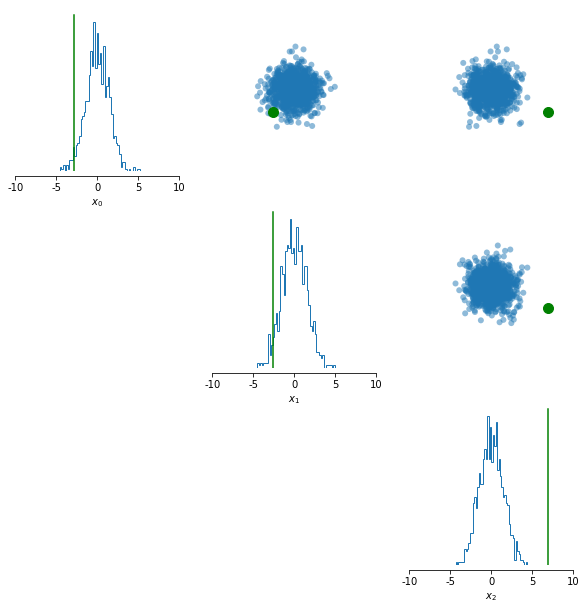

In [4]:
pairplot(simulator(prior.sample((1000,)), scale=simulator_scale), 
         upper="scatter", points=x_o, points_colors="g", limits=[[-10, 10]], 
         labels=[f"$x_{ii}$" for ii in range(num_dim)]);

## Other examples of model misspecification


- what we have here: one hyper-parameter (scale) of the simulator misspecified 
    - inference with `sbi` can fail or be biased (ongoing research)
    - not enough training data around parameters relevant for `x_o`
    - density-estimator ill-behaved when evaluated at `x_o`
- more severe: wrong model class
- prior misspecification
- do you know more examples? 

## Bayesian inference vs. Bayesian workflow

- Bayesian inference: 
    - obtain posterior
    - (or samples)
- Bayesian workflow:
    - model building
    - inference
    - model checking

<img src="figures/bayesian_worklow_chart.png" align="center" alt="beadexample" width="800"/> 
[Gelman et al. 2020]

## Recommended reading

- Gelman et al. 2020, "Bayesian workflow", 
https://arxiv.org/abs/2011.01808

- Michael Betancourt, "Towards a principled Bayesian Workflow", 2020
https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html



## Bayesian workflow in `sbi`

Which of the steps can we do in `sbi` (until now)?

- prior predictive checks
- convergence diagnostics (training logs)
- posterior predictive checks
- simulation-based calibration (Talts et al. 2018)

## Simulation-based calibration

- a check wether the inferred posterior is well calibrated
- using necessary conditions for valid posterior inference:


- **condition**: Suppose we have many separate observations $x_o^i$ simulated from parameters $\theta_o^i$. If we run the inference for each of them and obtain posterior samples $\theta^i \sim p(\theta | x_o^i)$, then the these samples (across different $x_o$) are distributed according to the prior! 

- **check**: repeat the inference for many $x_o^i$ and compute the rank of the corresponding $\theta_o^i$ under a set of generated posterior samples $\{\theta_j, \ldots, \theta_L\} \sim p(\theta | x_o^i)$. Check whether the ranks are distributed uniformly (for every posterior dimension separately).

<img src="figures/SBC-algorithm.png" align="center" alt="beadexample" width="1200"/> 

<img src="figures/SBC-ranking-formula.png" align="center" alt="beadexample" width="600"/> 

Talts et al. 2018

## Interpretation of SBC histograms

- uniformity is a necessary condition
- can be judged visually (or with standard uniformity (frequentists) checks)
- visual interpretation:

## Uniform vs auto-correlated posterior sampes

<img src="figures/SBC-plots-spikes-autocorrelation.png" align="center" alt="beadexample" width="1200"/> 

Talts et al. 2018

## Inverted U-shape: over-dispersion

<img src="figures/SBC-plots-reverted-U-shape-overdispersion.png" align="center" alt="beadexample" width="1200"/> 
Talts et al. 2018

## U-shape: under-dispersion

<img src="figures/SBC-plots-U-shape-underdispersion.png" align="center" alt="beadexample" width="1200"/> 
Talts et al. 2018

## Skewed: biased posterior

<img src="figures/SBC-plots-skewed-bias.png" align="center" alt="beadexample" width="1200"/> 
Talts et al. 2018

## Practical: Bayesian workflow in `sbi`

### Tasks
1) Take one the following inference problem (TBD) and perform as much of the Bayesian workflow as possible using `sbi`
- prior predictive checks
- convergence diagnostics
- posterior predictive checks
- [optional] implement and run simulation-based calibration

2) Is the inference you performed valid? 

## Discussing open questions

## References

- Gelman et al. 2020, "Bayesian workflow", 
https://arxiv.org/abs/2011.01808

- Michael Betancourt, "Towards a principled Bayesian Workflow", 2020
https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html


- Talts et al. 2018 "Validating Bayesian Inference Algorithms with Simulation-Based Calibration", https://arxiv.org/abs/1804.06788